# 3HSP x Fink

In [1]:
import pandas as pd
import numpy as np

from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

## Crossmatch: description

This notebook describes the crossmatch between the 3HSP catalog (https://www.ssdc.asi.it/3hsp/) and Fink ZTF alerts (https://fink-broker.org). 

The Fermi catalogs used has been downloaded and can be found under `data/3hsp`. The catalog is malformed, so we need to clean a bit the data:

In [2]:
pdf_3hsp = pd.read_csv('../data/3hsp/3hsp.csv', header=0)

# remove white spaces around column names
pdf_3hsp = pdf_3hsp.rename(columns={i:i.strip() for i in pdf_3hsp.columns})

# convert RA/Dec into degrees
pdf_3hsp['R.A.'] = pdf_3hsp['R.A.'].apply(lambda x: x.strip().replace('"', ''))
pdf_3hsp['Dec'] = pdf_3hsp['Dec'].apply(lambda x: x.strip().replace('"', ''))

coord = SkyCoord(
    pdf_3hsp[['R.A.', 'Dec']].apply(lambda x: '{} {}'.format(*x), axis=1).values, 
    unit=(u.hourangle, u.deg)
)

pdf_3hsp['ra'] = coord.ra.deg
pdf_3hsp['dec'] = coord.dec.deg


msg = """
---
Total: {} sources
""".format(len(pdf_3hsp))

print(msg)


---
Total: 2013 sources



In [3]:
pdf_3hsp.head(2)

,id,3HSP Source name,BZcat name,R.A.,Dec,NVSS/FIRSTflux density(mJy),X-ray flux d. @ 1keV (μJy),Log(peak flux),FOM,γ-ray counterpart,Fermi γ-ray slope,2WHSP name,ra,dec
0,1,"""3HSPJ000116.4+293534""","""""",00 01 16.37,+29 35 34.0,"""4""","""""","""-12.9?""",0.05,"""""","""""","""2WHSPJ000116.3+293534""",0.318208,29.592778
1,2,"""3HSPJ000117.1-315043""","""""",00 01 17.08,-31 50 43.0,"""7.2""","""0.23""","""-12.3?""",0.20,"""""","""""","""2WHSPJ000116.9-315043""",0.321167,-31.845278


The Fink data used are all the alerts from 11/2019 to 10/2022. As of 04/10/2022, there are 102,374,541 alerts available (https://fink-portal.org/stats).

We took all sources from Fermi, and all alerts from Fink, and we performed the crossmatch. To start, we set the crossmatch radius to 1 arcmin. For all match, we concatenate into unique _objects_ (in Fink an object can emit several alerts), and we join the data from Fermi catalogs, plus some data from Fink:
- ZTF object ID (`objectId`), Fink classification (`finkclass`), the vector of times (`cjd`), the vector of passbands (`cfid`), the vector of magnitudes (`dcmag`), and the vector of magnitude error estimates (`dcmagerr`)

The result of the crossmatch, per catalog, can be found under `data/crossmatch`:

In [4]:
pdf_fink_3hsp = pd.read_parquet('../data/crossmatch/3hsp_x_fink_1arcmin.parquet')

msg = """
---
Total: {} sources
Fraction of Fermi sources: {:.1f}%
""".format(
    len(pdf_fink_3hsp),  
    len(pdf_fink_3hsp)/len(pdf_3hsp)*100
)

print(msg)


---
Total: 470 sources
Fraction of Fermi sources: 23.3%



We have a total of 634 sources matching at 1 arcmin (about 17%).

## Classification of objects

Let's have a look at the classes of objects in Fink:

In [5]:
pdf_fink_3hsp\
    .groupby('finkclass')\
    .count()\
    .sort_values('objectId', ascending=False)[['objectId']]

,objectId
finkclass,
BLLac,312
Blazar,66
Unknown,48
Blazar_Candidate,13
QSO,7
RRLyr,4
Candidate_EB*,3
Star,2
Radio,2


Good, mostly BLLac & QSO. More interesting, there are some `Unknown` (i.e. no classification in Fink). We can also found likely false associations from the crossmatch, such as SN candidate, variable stars (EB*, V*, RRLyr, ...).

## ZTF lightcurves

In [6]:
# Number of object to display
N = 20

https://fink-portal.org/ZTF18abuufhd


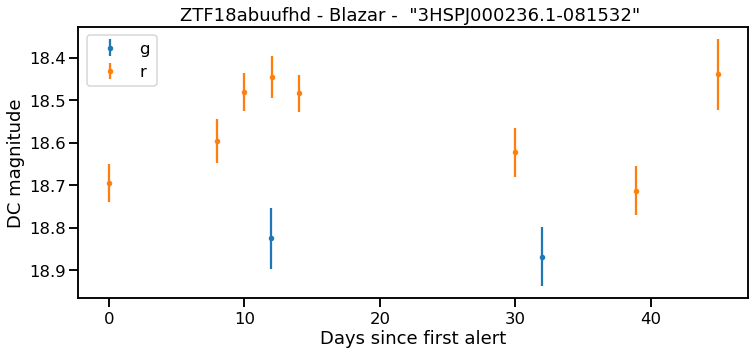

https://fink-portal.org/ZTF18abtworo


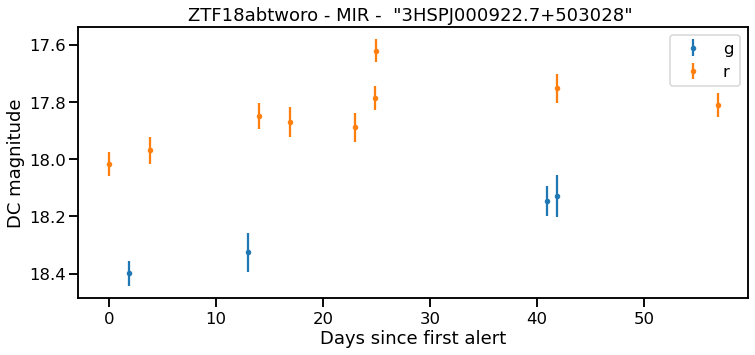

https://fink-portal.org/ZTF18abvwobq


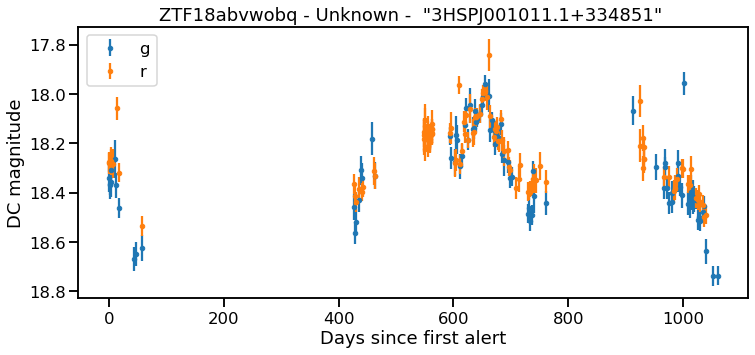

https://fink-portal.org/ZTF18abjhnbg


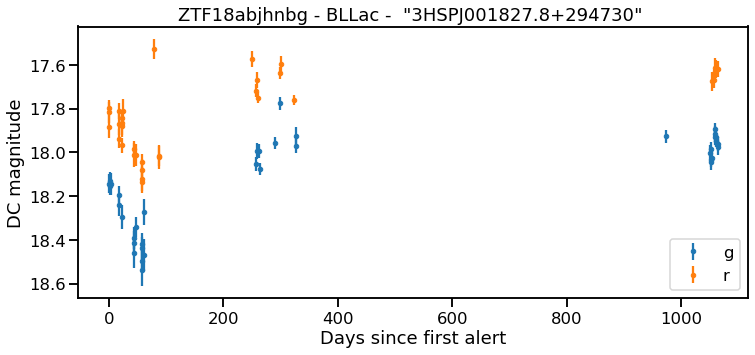

https://fink-portal.org/ZTF18acejbcb


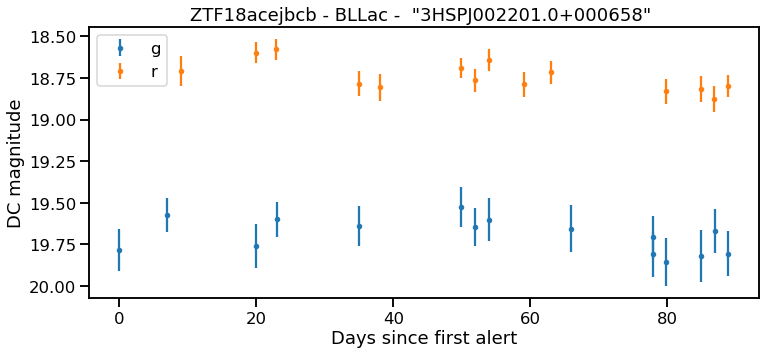

https://fink-portal.org/ZTF18abvydni


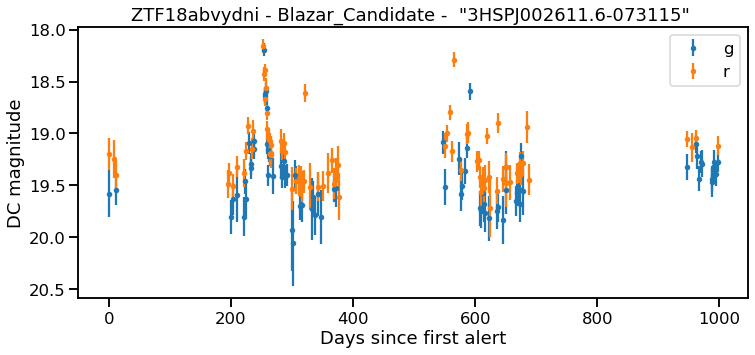

https://fink-portal.org/ZTF18acejefb


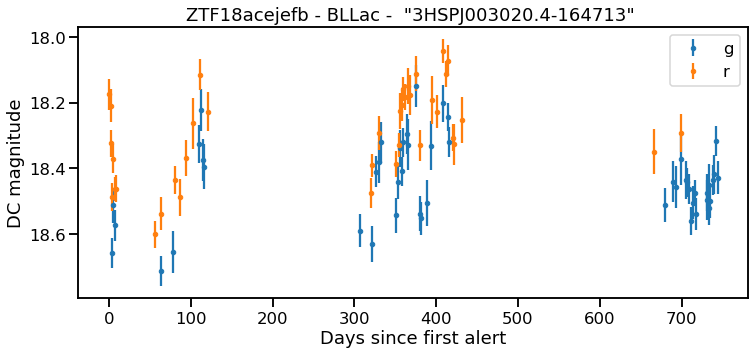

https://fink-portal.org/ZTF18abtftkf


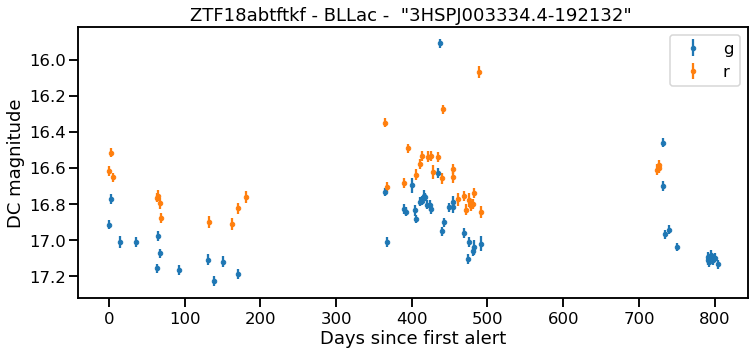

https://fink-portal.org/ZTF19abnavpf


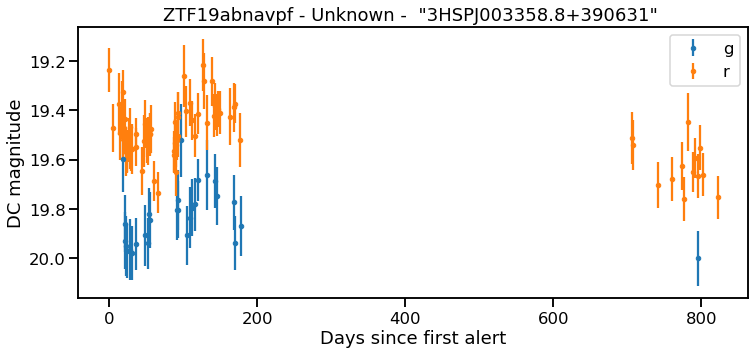

https://fink-portal.org/ZTF18abnyznq


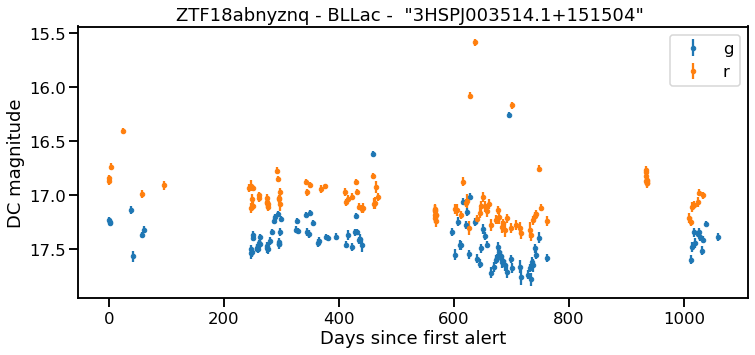

https://fink-portal.org/ZTF20abmucon


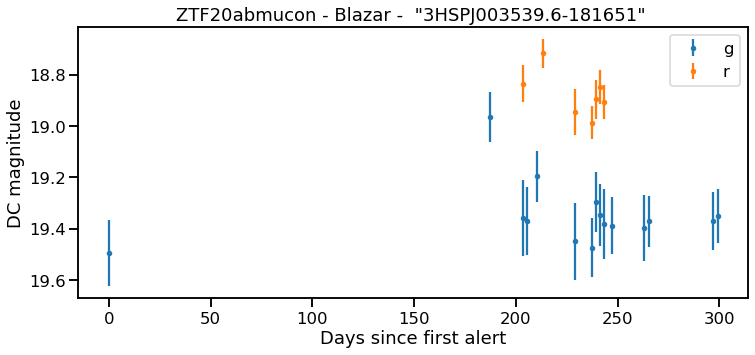

https://fink-portal.org/ZTF18acajzsp


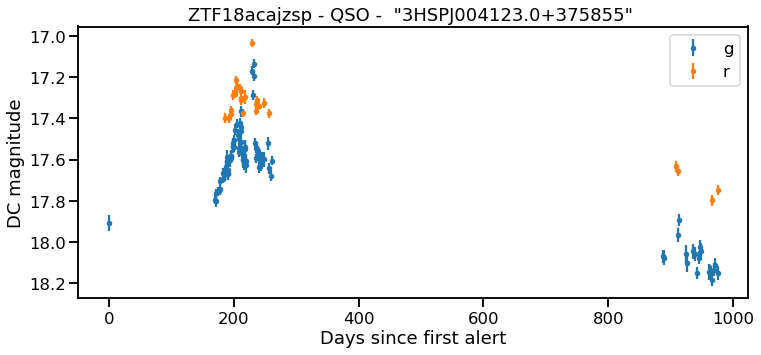

https://fink-portal.org/ZTF18aboejnm


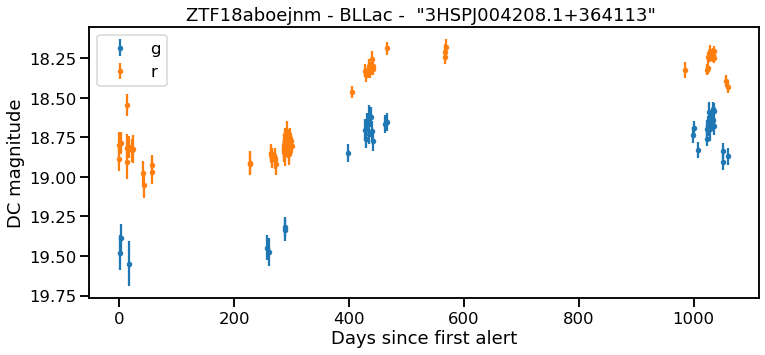

https://fink-portal.org/ZTF19abisbfd


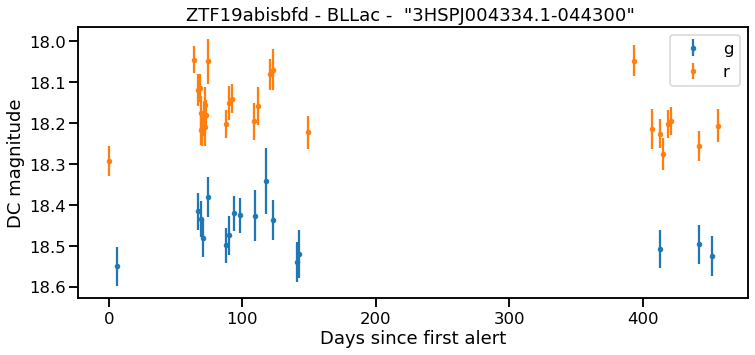

https://fink-portal.org/ZTF18acbudwf


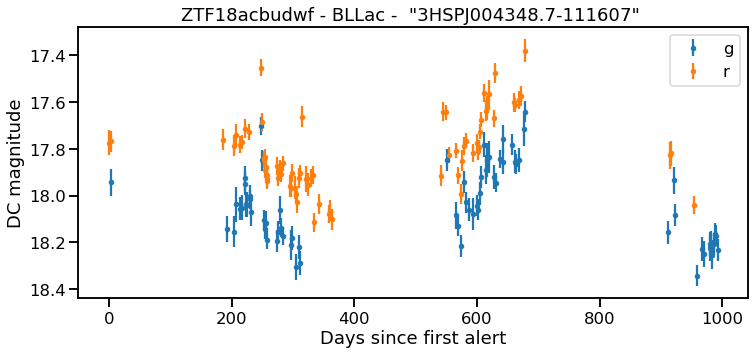

https://fink-portal.org/ZTF19achuafy


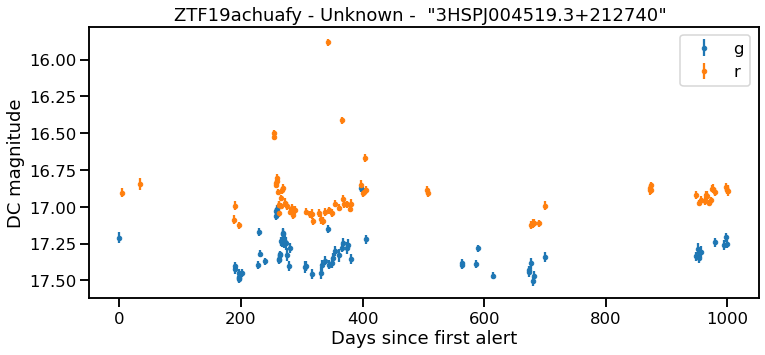

https://fink-portal.org/ZTF20acvfubc


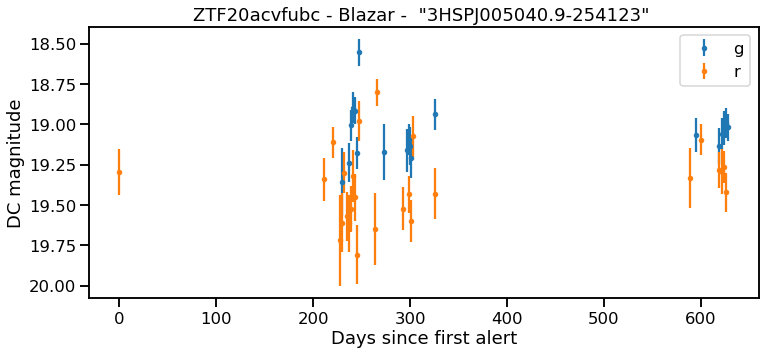

https://fink-portal.org/ZTF18abuvchc


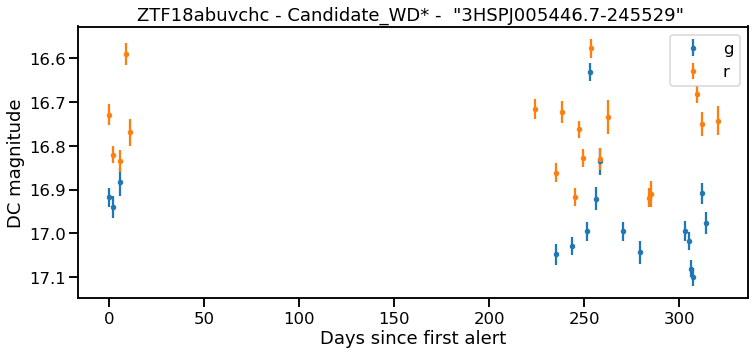

https://fink-portal.org/ZTF18abwfxtl


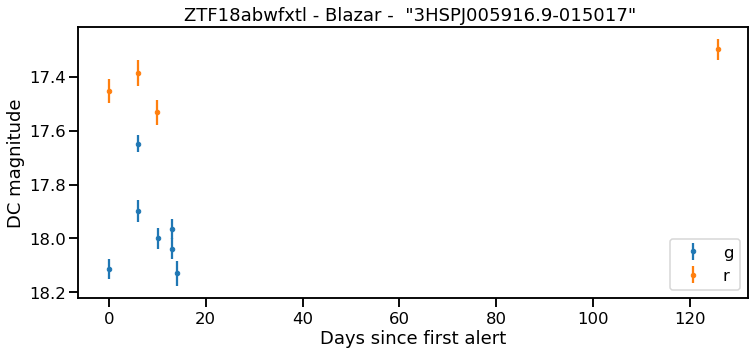

https://fink-portal.org/ZTF18acrugby


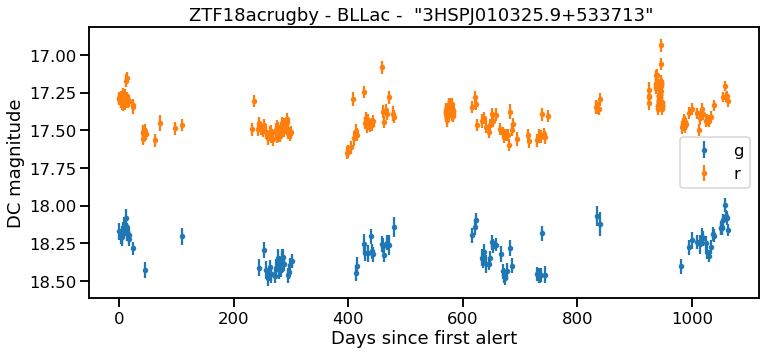

In [7]:
dicname = {1: 'g', 2: 'r'}
for index, row in enumerate(pdf_fink_3hsp.iterrows()):
    if index >= N:
        break
    data = row[1]
    print('https://fink-portal.org/{}'.format(data['objectId']))
    
    fig = plt.figure(figsize=(12, 5))
    
    for filt in [1, 2]:
        mask = data['cfid'] == filt
        if np.sum(mask) == 0:
            continue
        plt.errorbar(
            data['cjd'][mask] - np.sort(data['cjd'])[0], 
            data['dcmag'][mask], 
            data['dcmagerr'][mask], 
            ls='', 
            marker='.', 
            label=dicname[filt],
            color='C{}'.format(filt - 1)
        )
    plt.legend()
    plt.ylabel('DC magnitude')
    plt.xlabel('Days since first alert')
    plt.title('{} - {} - {}'.format(data['objectId'], data['finkclass'], data['3HSP Source name']))
    
    plt.gca().invert_yaxis()
    plt.show()

## Sky location

Crappy script to look at the sky distribution...

In [8]:
from collections import Counter
import healpy as hp

def plot_mwd(RA,Dec,color,ax, cmap='viridis', alpha=0.5, cb=True,org=0,title=None, cb_title='magnitude',projection='mollweide'):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    '''
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -= 360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    cm = ax.scatter(
        np.radians(x),
        np.radians(Dec), 
        c=color,
        alpha=alpha,
        marker='.',
        cmap=cmap
    )  # convert degrees to radians
    if cb:
        cb = fig.colorbar(cm)
        cb.set_label(cb_title)
        
    if title is not None:
        tick_labels = np.array(['', '120', '', '60', '', '0', '', '300', '', '240', ''])
        ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
        ax.set_title(title)
        ax.title.set_fontsize(15)
        ax.set_xlabel("RA")
        ax.xaxis.label.set_fontsize(12)
        ax.set_ylabel("Dec")
        ax.yaxis.label.set_fontsize(12)
        ax.grid(True)

def dec2theta(dec: float) -> float:
    """ Convert Dec (deg) to theta (rad)
    """
    return np.pi / 2.0 - np.pi / 180.0 * dec

def ra2phi(ra: float) -> float:
    """ Convert RA (deg) to phi (rad)
    """
    return np.pi / 180.0 * ra

def get_ppix(pdf, nside=1024):

    pixs = hp.ang2pix(
        nside, 
        dec2theta(pdf['ra'].values),
        ra2phi(pdf['dec'].values),
        lonlat=True
    )
    
    pdict = Counter(pixs)

    ppixs = [pdict[i] for i in pixs]
    
    return ppixs

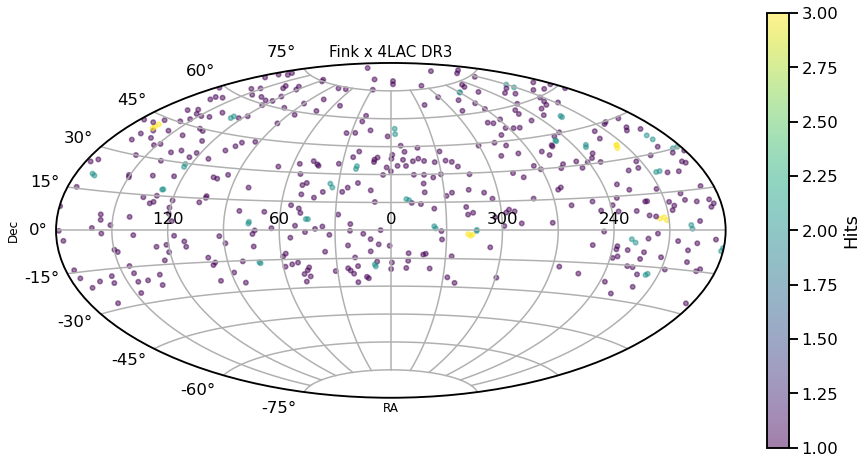

In [9]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='aitoff')

ppixs = get_ppix(pdf_fink_3hsp, 1024)
plot_mwd(
    pdf_fink_3hsp['ra'].values, 
    pdf_fink_3hsp['dec'].values, 
    ppixs, 
    ax=ax, 
    title='Fink x 4LAC DR3', 
    cb_title='Hits',
    alpha=0.5,
    org=0
)

## Next

1. Check time correlation
2. Play with bigger crossmatch radius
3. play with the multi-wavelength data :-)